# Download dataset from Kaggle

In [53]:
import kagglehub

path = kagglehub.dataset_download("warcoder/nutrient-deficient-banana-plant-leaves")

print("Path to dataset files:", path)
# C:\Users\jpark\.cache\kagglehub\datasets\warcoder\nutrient-deficient-banana-plant-leaves\versions\1

100%|██████████| 157M/157M [00:17<00:00, 9.41MB/s] 

Extracting files...


Path to dataset files: C:\Users\jpark\.cache\kagglehub\datasets\warcoder\nutrient-deficient-banana-plant-leaves\versions\1


# Move the dataset from local machine's cache to the root folder

In [54]:
import shutil
import os

# Define paths
src_folder = os.path.expanduser(path)
dst_folder = "./dataset"

shutil.move(src_folder, dst_folder)

'./dataset'

# Process images (Resize and Augment)

In [55]:
# PROCESSING IMAGES
  # resizing: for uniform image sizes (set to 640x640)
  # augmentation: for balancing of training dataset

import cv2
import os
import numpy as np
import albumentations as A
import random
import tensorflow as tf

dataset_path = "./dataset/Nutrient Deficient Banana Plant Leaves/Nutrient Deficient RAW Images of Banana Leaves"

# Target image size
TARGET_SIZE = (224, 224)

# Maximum images per class
MAX_IMAGES_PER_CLASS = 1000

# Sequential augmentation functions 
transform = A.Compose([
    A.Rotate(limit=20), # Randomly rotates the image between -20 and +20 degrees
    A.HorizontalFlip(p=0.5), # probability of it happening (0.5: 50% chance of applying)
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.3),
])

# Function to resize (224) and augment images 
def process_images(path):
    for class_folder in os.listdir(path):
        class_path = os.path.join(path, class_folder)

        # Get list of images
        img_files = os.listdir(class_path)
        original_count = len(img_files)

        # Resize and convert images
        for img_name in img_files:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Warning: Couldn't read {img_path}")
                continue

            img_resized = cv2.resize(img, TARGET_SIZE)
            cv2.imwrite(img_path, img_resized)

        # Calculate how many more images are needed
        needed_augmentations = max(0, MAX_IMAGES_PER_CLASS - original_count)

        # Generate only the required number of augmented images
        for i in range(needed_augmentations):
            img_name = random.choice(img_files)  # Pick a random image
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            # transform image to make augmented images
            # ['image'] used because transform returns dictionary and we only want the image
            augmented = transform(image=img)['image']
            aug_img_name = f"{os.path.splitext(img_name)[0]}_aug{i}.jpg"
            cv2.imwrite(os.path.join(class_path, aug_img_name), augmented)

        print(f"{class_folder} processing complete now with {min(MAX_IMAGES_PER_CLASS, original_count + needed_augmentations)} images")


# process function call
process_images(dataset_path)

boron processing complete now with 1000 images
calcium processing complete now with 1000 images
healthy processing complete now with 1000 images
iron processing complete now with 1000 images
magnesium processing complete now with 1000 images
manganese processing complete now with 1000 images
potassium processing complete now with 1000 images
sulphur processing complete now with 1000 images
zinc processing complete now with 1000 images


# Show sample image

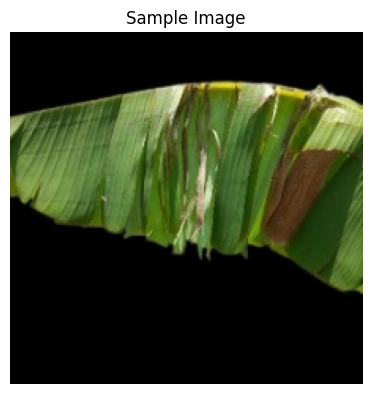

In [56]:
import matplotlib.pyplot as plt

# Show sample image
img_path = "./dataset/Nutrient Deficient Banana Plant Leaves/Nutrient Deficient RAW Images of Banana Leaves/boron/b_2.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct color display

# Show original and augmented images side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Sample Image")
plt.axis("off")

plt.show()

In [57]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

In [58]:
img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% validation
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)


Found 7200 images belonging to 9 classes.
Found 1800 images belonging to 9 classes.


In [59]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze base

print(f"Total layers in base model: {len(base_model.layers)}")

Total layers in base model: 154


In [70]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(train_gen.class_indices), activation='softmax')
])

print(f"How many classes: {len(train_gen.class_indices)}")

How many classes: 9


In [71]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 2,339,721 (8.93 MB)

 Non-trainable params: 83,392 (325.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Train model with early stopping
history = model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[early_stopping, lr_scheduler])

# Unfreeze last few layers for fine-tuning  
base_model.trainable = True
for layer in base_model.layers[:50]:  # Freeze first 100 layers
    layer.trainable = False 

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.6919 - loss: 0.9295 - val_accuracy: 0.3867 - val_loss: 3.0098 - learning_rate: 5.0000e-04
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 296s 1s/step - accuracy: 0.7911 - loss: 0.5807 - val_accuracy: 0.4494 - val_loss: 2.3842 - learning_rate: 5.0000e-04
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.8095 - loss: 0.5268 - val_accuracy: 0.4156 - val_loss: 2.6393 - learning_rate: 5.0000e-04
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8152 - loss: 0.5070
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
225/225 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.8152 - loss: 0.5070 - val_accuracy: 0.4206 - val_loss: 2.5456 - learning_rate: 5.0000e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.8366 - loss: 0.4564 - val_accuracy: 0.4689 - val_loss: 2.4450 - learning_rate: 2.5000e-04
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.

In [ ]:
# Recompile model with lower learning rate for fine-tuning
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Continue training with fine-tuning and early stopping
fine_tune_epochs = 20
history_fine = model.fit(train_gen, epochs=fine_tune_epochs, validation_data=val_gen, callbacks=[early_stopping])

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 333s 1s/step - accuracy: 0.3237 - loss: 2.0377 - val_accuracy: 0.3711 - val_loss: 1.8408
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.5542 - loss: 1.2731 - val_accuracy: 0.3778 - val_loss: 1.8976
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step - accuracy: 0.6280 - loss: 1.0715 - val_accuracy: 0.3833 - val_loss: 1.8387
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.6636 - loss: 0.9559 - val_accuracy: 0.3861 - val_loss: 1.8161
Epoch 5/20
 10/225 ━━━━━━━━━━━━━━━━━━━━ 3:38 1s/step - accuracy: 0.6364 - loss: 0.9758

KeyboardInterrupt: 

In [ ]:
model.save('banana_deficiency_model.h5')

In [ ]:
# Plot training history with labels and title
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
plt.plot(history.history['accuracy'], label='Initial Train Accuracy', linestyle='dashed', marker='o')
plt.plot(history.history['val_accuracy'], label='Initial Validation Accuracy', linestyle='dashed', marker='o')
plt.plot(history_fine.history['accuracy'], label='Fine-Tuned Train Accuracy', linestyle='solid', marker='s')
plt.plot(history_fine.history['val_accuracy'], label='Fine-Tuned Validation Accuracy', linestyle='solid', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Training and Fine-Tuning Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
plt.plot(history.history['loss'], label='Initial Train Loss', linestyle='dashed', marker='o')
plt.plot(history.history['val_loss'], label='Initial Validation Loss', linestyle='dashed', marker='o')
plt.plot(history_fine.history['loss'], label='Fine-Tuned Train Loss', linestyle='solid', marker='s')
plt.plot(history_fine.history['val_loss'], label='Fine-Tuned Validation Loss', linestyle='solid', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Training and Fine-Tuning Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [ ]:
# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_fine.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history_fine.history['loss'], label='Train Loss', marker='o', color='red')
plt.plot(history_fine.history['val_loss'], label='Validation Loss', marker='o', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.0, 1.0)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# Display sample predictions
import random

# Ensure class names are defined
class_names = ['boron', 'calcium', 'healthy', 'iron', 'magnesium', 'manganese', 'potassium', 'sulphur', 'zinc']
num_classes = len(class_names)

# Get all images and labels from the validation generator
# Note: assumes val_gen is not shuffled
all_images = []
all_labels = []

for i in range(len(val_gen)):
    imgs, lbls = val_gen[i]
    all_images.extend(imgs)
    all_labels.extend(lbls)

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Randomly select one image per class
selected_indices = []
for class_idx in range(num_classes):
    indices = np.where(np.argmax(all_labels, axis=1) == class_idx)[0]
    if len(indices) > 0:
        selected_indices.append(random.choice(indices))

# Plot
plt.figure(figsize=(15, 10))

for i, idx in enumerate(selected_indices):
    image = all_images[idx]
    label = class_names[np.argmax(all_labels[idx])]
    prediction = class_names[np.argmax(model.predict(np.expand_dims(image, axis=0)))]
    color = "green" if label == prediction else "red"
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"True: {label}\nPred: {prediction}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()